# **TMBD Exploratory Data Analysis**

### <u> **Genre Popularity** <u>

Firstly, I delved into the popularity of different genres within the dataset. To do this, I extracted the genres from the 'genre' column using the 'extract_genres' function (outlined below) and organized them into a more streamlined column called 'extracted_genres'.

###### Unhide for code showing library/data imports and extract_genres function.

In [5]:
# Import the required libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [6]:
# Read in the TMDB data:
df = pd.read_csv("TMDB_movies.csv")
df_new = df.copy()

In [7]:
# Extract the genres:
def extract_genres(x):
    ''' Function to extract genres for each datapoint. '''
    x = ast.literal_eval(x) ## Transform '['name', 'id']' back into ['name', 'id']
    Genres = [] ## Empty list to store the genres
    
    # Iterate through each dictionary
    for item in x: ## iterate for each dictionary in our list
        Genres.append(item['name']) ## Grab the 'name' key for each dictionary
        
    # Return the Genres
    return Genres

## Apply the function to genres
df_new['extracted_genres'] = df_new['genres'].apply(extract_genres)

###### 

I then found the **average popularity for each genre** using the following method:
- Expand the 'extracted_genre' column into individual rows so each row has only one genre within it.
- Group by genre.
- Find the mean for each genre.
- Sort the means in descending order.
- Visualise the data.

###### Unhide for code:

In [11]:
# Expand the 'extracted_genre' column into individual rows:
df_expanded = df_new.explode('extracted_genres').copy()

# Find the mean for each genre and sort them:
df_expanded_pop_avg = df_expanded.groupby('extracted_genres')[['popularity']]\
                        .mean()\
                        .sort_values(by = 'popularity', ascending = False)\
                        .rename(columns = {'popularity': 'average_popularity'})\
                        .reset_index()

###### 

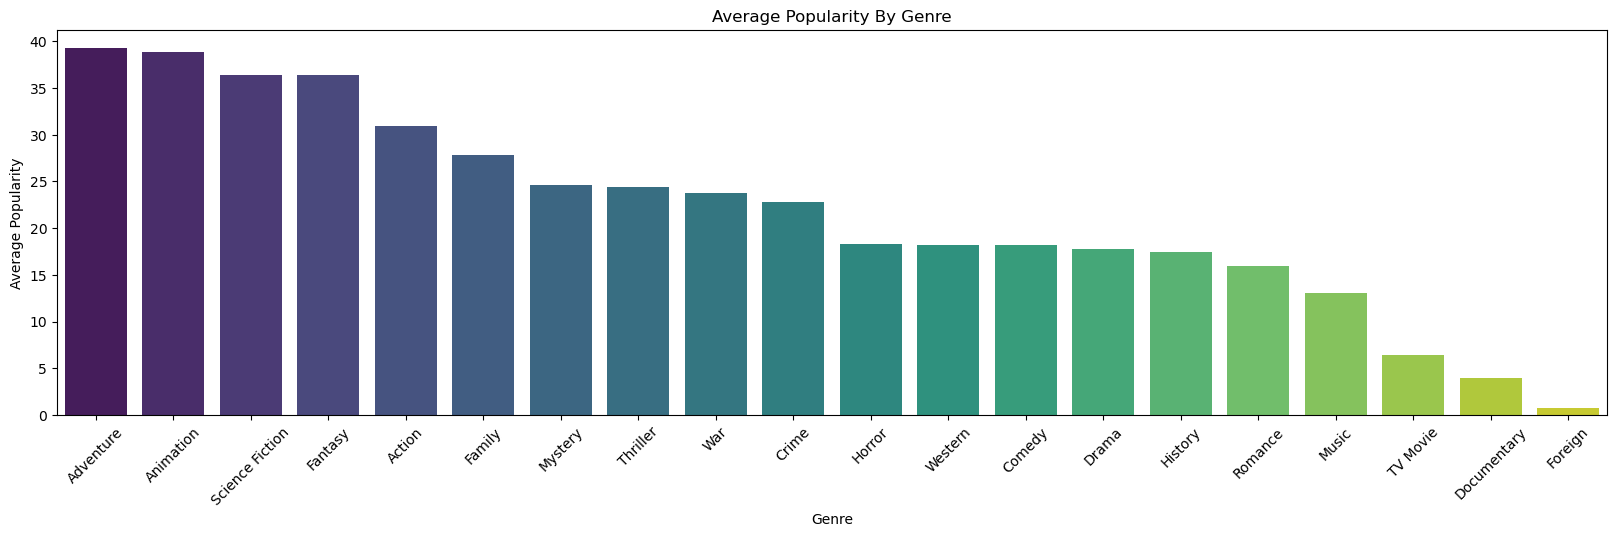

In [13]:
# Plot the data:
plt.figure(figsize = (20,5))
sns.barplot(data = df_expanded_pop_avg,
            x = 'extracted_genres',
            y = 'average_popularity',
            hue = 'extracted_genres',
            palette = 'viridis')
plt.title('Average Popularity By Genre')
plt.xlabel('Genre')
plt.ylabel('Average Popularity')
plt.xticks(rotation = 45)
plt.show()

The graph above shows that films categorised as 'Adventure', 'Animation' and 'Science Fiction' are the most popular on average with 'Adventure' reaching a popularity score of almost 40. The least favourable genre appears to be 'Foreign' and this has a popularity score of less than 1.

To investigate these popularity scores more thoroughly, I delved into the **average budget given to each genre** to see whether this could influence the scores.

###### Unhide for code:

In [17]:
# Find the average budget for each genre:
df_expanded_budget_avg = df_expanded.groupby('extracted_genres')[['budget']]\
                        .mean()\
                        .sort_values(by = 'budget', ascending = False)\
                        .rename(columns = {'budget': 'average_budget'})\
                        .reset_index()



###### 

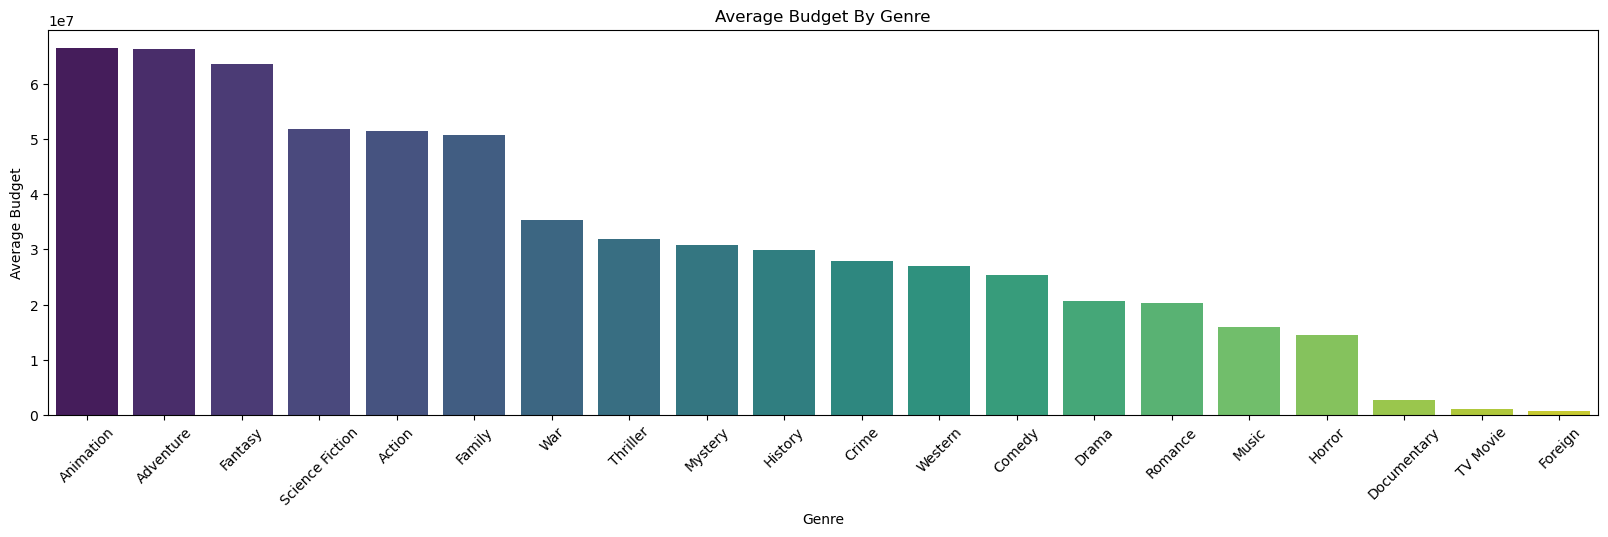

In [19]:
# Plot the data:
plt.figure(figsize = (20,5))
sns.barplot(data = df_expanded_budget_avg,
            x = 'extracted_genres',
            y = 'average_budget',
            hue = 'extracted_genres',
            palette = 'viridis')
plt.title('Average Budget By Genre')
plt.xlabel('Genre')
plt.ylabel('Average Budget')
plt.xticks(rotation = 45)
plt.show()

The top five genres are consistent across both graphs, with a similar ranking order for all genres. This is interesting because it suggests a relationship between higher budgets and more popular genres. It's possible that films with larger budgets tend to be more extravagant, feature better actors, or offer higher production quality, which could make them more engaging and well-received. However, the fact that the top genres remain consistent across both the budget and popularity graphs could also suggest that these genres are inherently more appealing to larger audiences which may then draw in greater investment. It may not only be the bigger budgets that lead to higher popularity, but also the genre's intrinsic appeal. Understanding this relationship may help studios and film companies allocate their resources to genres that are likely to yield the best results and it may also help TMDB to base their more general film recommendations on the genres with higher popularity.

#### Most Popular Film

Following on from this I investigated the **most popular film** to explore some of it's interesting features and then compared it to films which feature the same genres.

In [23]:
# Find the most popular film:
df_new[df_new['popularity'] == max(df_new['popularity'])][['original_title','extracted_genres','popularity','runtime']]

,original_title,extracted_genres,popularity,runtime
546,Minions,"[Family, Animation, Adventure, Comedy]",875.581305,91.0


I found the most popular film is 'Minions' and this features the Family, Animation, Adventure and Comedy genres (two of the top five most popular genres on average). It's ranked within the top 10 most revenue generating films within the dataset which is no surprise given its high popularity, but what's odd is that it has an unexpectedly low runtime of 91 minutes. The graph below shows the average popularity of films of different lengths and the clear winners are films between 150-200 minutes. On average films in this category have a popularity score of over double what films in the 50-100 minute category have so somehow Minions has outperformed it's category.

###### Unhide for code:

In [26]:
# Remove the 2 null values:
run_df = df_new.dropna(axis = 0, how = 'any', subset = ['runtime']).copy()

# Use the '.cut()' method to create runtime categories:
run_buckets = [0, 50, 100, 150, 200, 250, 300, 350]
run_buckets_name = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350']
run_df['Runtime Buckets'] = pd.cut(run_df['runtime'],
                                  bins = run_buckets, 
                                  labels = run_buckets_name, 
                                  include_lowest = True) 

# Find the average popularity for each runtime category:
run_df_avg = run_df.groupby('Runtime Buckets', observed = True)[['popularity']]\
                .mean()\
                .sort_values(by = 'popularity', ascending = False)\
                .rename(columns = {'popularity': 'average_popularity'})\
                .reset_index()

###### 

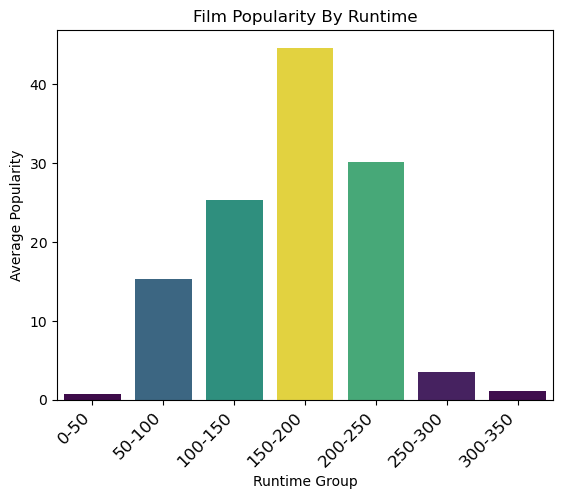

In [28]:
# Plot the data:
sns.barplot(x = 'Runtime Buckets',
            y = 'average_popularity',
              data = run_df_avg,
              hue = 'average_popularity',
              palette = 'viridis')
plt.xlabel('Runtime Group')
plt.ylabel('Average Popularity')
plt.xticks(rotation = 45,
           horizontalalignment = 'right',
           fontweight = 'light',
           fontsize = 'large')
plt.title('Film Popularity By Runtime')
plt.legend().remove()
plt.show()

To see whether it's genre combinaion is what's driving it's high popularity I compared it to 33 other films having only these four genres by examining some aggregate figures.

In [30]:
# Find the films containing Family, Animation, Adventure and Comedy as genres:
minion_genre_df = df_new[df_new['extracted_genres'].apply(lambda x: set(x) == set(['Family', 'Animation', 'Adventure', 'Comedy']))]

# Look at the stats for all other films:
minion_genre_df[minion_genre_df['original_title'] != 'Minions'].describe().loc[['mean']]

,budget,id,popularity,revenue,runtime,vote_average,vote_count
mean,8.321212e+07,66725.757576,43.34513,2.983826e+08,89.606061,6.315152,1541.515152


In [31]:
# Compare with stats for minion film:
df_new[df_new['popularity'] == max(df_new['popularity'])][['budget','id', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']]

,budget,id,popularity,revenue,runtime,vote_average,vote_count
546,74000000,211672,875.581305,1156730962,91.0,6.4,4571


Surprisingly, there is a substantially lower budget for Minions compared to the other films in these genres but it's popularity is 20 times larger! This highlights a really important point because if filmakers focus on the right things and target the right audiences they can create a really successful film without it breaking the bank. It should encourage a shift towards more cost-effective, creative projects.

<img src = "https://images.unsplash.com/photo-1595624871930-6e8537998592?w=500&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8Mnx8bWluaW9ufGVufDB8fDB8fHww">

### <u> **Popularity Over Time** <u>

Continuing with the theme of popularity, I explored whether there has been an increase in **film popularity over time** using the following method:
- Remove the row in the dataset with a null value in the 'release_date' column.
- Create a new column called 'year' which contains the release year.
- Group by year.
- Calculate the mean popularity score for each year.
- Sort the means in descending order.
- Visualise the data.

###### Unhide for code:

In [37]:
# Drop the null value since there is only 1 out of 4803:
df_new_na = df_new.dropna(axis = 0, how = 'any', subset = ['release_date']).copy()

# Create a year column and calculate the mean popularity for each year:
df_new_na['year'] = df_new_na['release_date'].apply(lambda x: x.split('-')[0])
df_new_avg = df_new_na.groupby('year')[['popularity']].mean().rename(columns = {'popularity': 'average_popularity'}).reset_index()

###### 

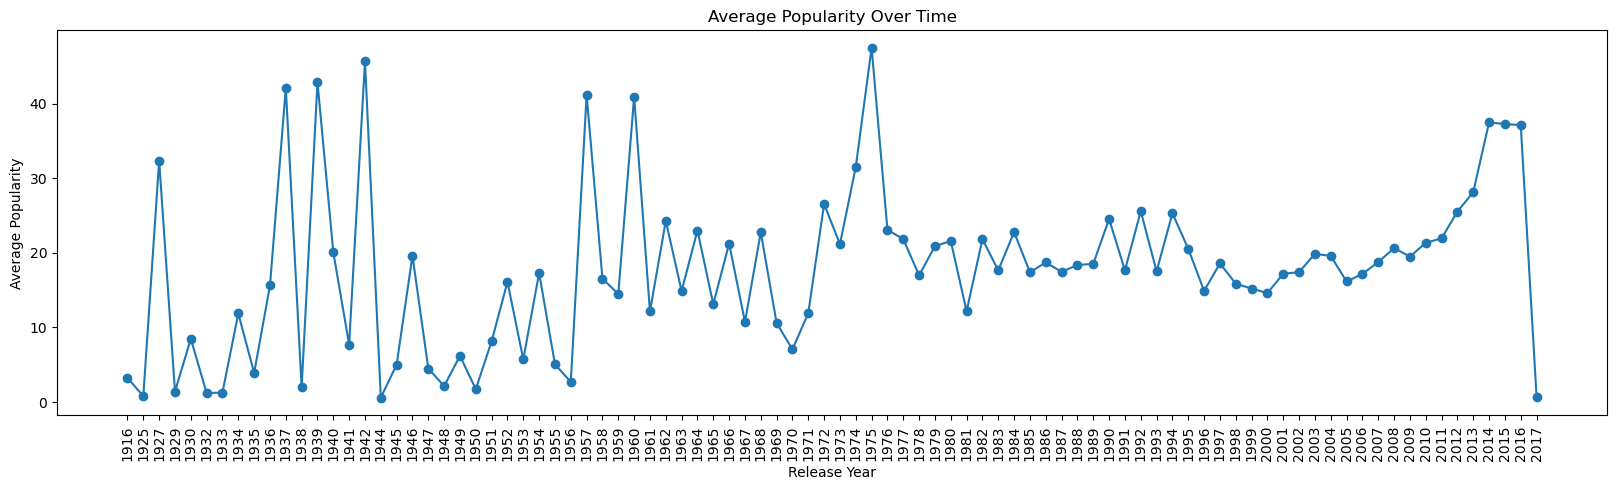

In [39]:
# Plot the data:
plt.figure(figsize=(20, 5))
plt.plot(df_new_avg['year'], df_new_avg['average_popularity'], marker='o')
plt.xticks(rotation=90)
plt.title('Average Popularity Over Time')
plt.xlabel('Release Year')
plt.ylabel('Average Popularity')
plt.show()

The average popularity shows a general upward trend over time, athough it experiences significant fluctuations. There is an immediate drop off in 2017 which I investigated further to find the cause.

In [41]:
# Find 2017 films:
df_new_na[df_new_na['year'] == '2017']

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,extracted_genres,year
4255,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10751, ""...",http://www.growingupsmithmovie.com,426469,[],en,Growing Up Smith,"In 1979, an Indian family moves to America wit...",0.71087,[],...,0,102.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,It’s better to stand out than to fit in.,Growing Up Smith,7.4,7,"[Comedy, Family, Drama]",2017


There's only one film in this dataset that was released in 2017, called 'Growing Up Smith'. However what's really interesting about this film in particular is that it has been released having had no production company backing it and also no budget. Additionally, it's made no revenue so these popularity ratings have come from people who haven't paid to watch the film. Another intersting feature is that it only has a vote count of 7 which is drastically smaller than the average of 690.

I compared this film to others with these properties (no budget, no production company and no production country) to see if there was anything else that could be driving its low popularity.

###### Unhide for code:

In [45]:
# Filter for the features above:
df_GUS = df_new_na[(df_new_na['budget'] == 0) &\
                    (df_new_na['production_companies'] == '[]') &\
                    (df_new_na['production_countries'] == '[]')]

###### 

In [47]:
# Stats for the other similar films:
df_GUS[df_GUS['original_title'] != 'Growing Up Smith'].describe().loc[['mean']]

,budget,id,popularity,revenue,runtime,vote_average,vote_count
mean,0.0,140469.034188,0.832398,31998.521368,80.846154,4.294872,7.393162


In [48]:
# Stats for Growing Up Smith:
df_new_na[df_new_na['year'] == '2017'][['budget', 'id', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']]

,budget,id,popularity,revenue,runtime,vote_average,vote_count
4255,0,426469,0.71087,0,102.0,7.4,7


Generally, it looks as though films with these properties don't have high popularity because the average sits at 0.83 which is only marginally higher than Growing Up Smith. A key takeaway from this is that films without a budget, a production company and a production country tend to struggle with gaining popularity, likely due to limited exposure and marketing. This highlights a potential challenge faced by independent films and could influence TMDB's future recommendations for films in this category.

<img src = "https://plus.unsplash.com/premium_photo-1664298513288-456716b3023f?w=500&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8MTN8fGVtcHR5JTIwd2FsbGV0fGVufDB8fDB8fHww">